<a href="https://colab.research.google.com/github/AliBenovaa/IANNwTF_Group24/blob/main/Copy_of_Homework06Group24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import numpy as np
import tqdm 
#import matplotlib as plt
import matplotlib.pyplot as plt

%load_ext tensorboard


train_ds, test_ds =tfds.load("cifar10", split =["train","test"], as_supervised=True)


def prepare_cifar_data(cifar):
  #convert data from uint64 to float32
  cifar = cifar.map(lambda img, target: (tf.cast(img, tf.float32),target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [0, 1]
  cifar = cifar.map(lambda img, target: ((img/128.)-1., target))
  cifar = cifar.map(lambda img, target: (img, tf.cast(target,tf.int32)))
  #create one-hot targets
  cifar = cifar.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  cifar = cifar.cache()
  #shuffle, batch, prefetch
  cifar = cifar.shuffle(1000)
  cifar = cifar.batch(16)
  cifar = cifar.prefetch(20)
  #return preprocessed dataset
  return cifar

train_ds = train_ds.apply(prepare_cifar_data)
test_ds = test_ds.apply(prepare_cifar_data)

def try_model(model, ds):
  for x, t in ds.take(5):
    y = model(x)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteAEP9Y2/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteAEP9Y2/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [54]:

class BasicConv(tf.keras.Model):
    def __init__(self):
    
        super(BasicConv, self).__init__()

        # optimizer, loss function and metrics
        self.metrics_list = [tf.keras.metrics.CategoricalAccuracy(name="acc"),
                             tf.keras.metrics.Mean(name="loss")]

        self.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
        
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()


        self.convlayer1 = tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu', input_shape = (32,32,3))
        self.pooling = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.convlayer2 = tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01))
        self.pooling2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        
        self.convlayer3 = tf.keras.layers.Conv2D(128,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01))
        self.pooling3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        
        self.convlayer4 = tf.keras.layers.Conv2D(256,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01))

        self.global_pool = tf.keras.layers.MaxPool2D((2,2))
        self.flatten = tf.keras.layers.Flatten()
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.dense1 = tf.keras.layers.Dense(64,activation = 'relu')
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.out = tf.keras.layers.Dense(10, activation='softmax')
        #self.dropout_layer = tf.keras.layers.Dropout(rate=0.2)

    def call(self,inputs):

        x = self.convlayer1(inputs)
        x = self.pooling(x)
        x = self.convlayer2(x)
        x = self.pooling2(x)
        x = self.convlayer3(x)
        x = self.pooling3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.batchnorm1(x)
        x = self.dense1(x)
        x = self.batchnorm2(x)
        x = self.out(x)
        return  x



     # 3. metrics property
    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model



    # 4. reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()


     #train_step method
    @tf.function
    def train_step(self, data):
        img1, label = data
        
        with tf.GradientTape() as tape:
            output = self(img1, training=True)
            loss = self.loss_function(label, output) + self.losses
    
            
        gradients = tape.gradient(loss, self.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
        
        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)
        
        # return a dictionary with metric names as keys and metric results as values
        return {m.name : m.result() for m in self.metrics}


        

   # 6. test_step method
    @tf.function
    def test_step(self, data):
        img1, label = data
        # same as train step (without parameter updates)
        output = self(img1, training=False)
        loss = self.loss_function(label, output)
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)
        
        return {m.name : m.result() for m in self.metrics}

    

In [22]:
class ResidualConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters):
    super(ResidualConnectedCNNLayer, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu')

  def call(self, x):
    c = self.conv(x)
    x = c+x
    return x

class ResidualConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, depth, layers):
    super(ResidualConnectedCNNBlock, self).__init__()
    self.deeper_layer = tf.keras.layers.Conv2D(filters=depth, kernel_size=3, padding='same', activation='relu')
    self.layers = [ResidualConnectedCNNLayer(depth) for _ in range(layers)]

  def call(self, x):
    x = self.deeper_layer(x)
    for layer in self.layers:
      x = layer(x)
    return x

class ResidualConnectedCNN(tf.keras.Model):
  def __init__(self):
    super(ResidualConnectedCNN, self).__init__()


    # optimizer, loss function and metrics  
    self.metrics_list = [tf.keras.metrics.CategoricalAccuracy(name="acc"),
                             tf.keras.metrics.Mean(name="loss")]

    self.optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate = 0.0001,momentum = 0.99,) #tf.keras.optimizers.Adam(learning_rate = 0.00001)
        
    self.loss_function = tf.keras.losses.CategoricalCrossentropy()
  
    self.residualblock1 = ResidualConnectedCNNBlock(24,4)
    self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)
    self.residualblock2 = ResidualConnectedCNNBlock(48,4)
    self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.residualblock3 = ResidualConnectedCNNBlock(96,4)
    self.globalpooling = tf.keras.layers.GlobalAvgPool2D()
    
    self.out = tf.keras.layers.Dense(10, activation='softmax',activity_regularizer=tf.keras.regularizers.L2(0.01))


  
  def call(self,x):
    x = self.residualblock1(x)
    x = self.pooling1(x)
    x = self.residualblock2(x)
    x = self.pooling2(x)
    x = self.residualblock3(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x



      # 3. metrics property
  @property
  def metrics(self):
      return self.metrics_list
      # return a list with all metrics in the model



  # 4. reset all metrics objects
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()


    #train_step method
  @tf.function
  def train_step(self, data):
      img1, label = data
      
      with tf.GradientTape() as tape:
          output = self(img1, training=True)
          loss = self.loss_function(label, output)
  
          
      gradients = tape.gradient(loss, self.trainable_variables)
      
      self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
      
      # update the state of the metrics according to loss
      self.metrics[0].update_state(label, output)
      self.metrics[1].update_state(loss)
      
      # return a dictionary with metric names as keys and metric results as values
      return {m.name : m.result() for m in self.metrics}


        

  # 6. test_step method
  @tf.function
  def test_step(self, data):
      img1, label = data
      # same as train step (without parameter updates)
      output = self(img1, training=False)
      loss = self.loss_function(label, output)
      self.metrics[0].update_state(label, output)
      self.metrics[1].update_state(loss)
      
      return {m.name : m.result() for m in self.metrics}


resnet_model = ResidualConnectedCNN()
try_model(resnet_model, train_ds)

In [48]:
class DenselyConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters):
    super(DenselyConnectedCNNLayer, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu')

  def call(self, x):
    c = self.conv(x)
    x = tf.concat((x,c), axis=-1)
    return x

class DenselyConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, layers):
    super(DenselyConnectedCNNBlock, self).__init__()
    self.layers = [DenselyConnectedCNNLayer(num_filters) for _ in range(layers)]

  def call(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


class DenselyConnectedCNN(tf.keras.Model):
  def __init__(self):
    super(DenselyConnectedCNN, self).__init__()


    # optimizer, loss function and metrics
    self.metrics_list = [tf.keras.metrics.CategoricalAccuracy(name="acc"),
                             tf.keras.metrics.Mean(name="loss")]

    self.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
        
    self.loss_function = tf.keras.losses.CategoricalCrossentropy()



    self.denseblock1 = DenselyConnectedCNNBlock(24,4)
    self.pooling1 = tf.keras.layers.MaxPooling2D()

    self.denseblock2 = DenselyConnectedCNNBlock(24,4)
    self.pooling2 = tf.keras.layers.MaxPooling2D()

    self.denseblock3 = DenselyConnectedCNNBlock(24,4)
    self.globalpooling = tf.keras.layers.GlobalAvgPool2D()
    self.out = tf.keras.layers.Dense(10, activation='softmax')

  def call(self,x):
    x = self.denseblock1(x)
    x = self.pooling1(x)
    x = self.denseblock2(x)
    x = self.pooling2(x)
    x = self.denseblock3(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x


      # 3. metrics property
  @property
  def metrics(self):
      return self.metrics_list
      # return a list with all metrics in the model



  # 4. reset all metrics objects
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()


    #train_step method
  @tf.function
  def train_step(self, data):
      img1, label = data
      
      with tf.GradientTape() as tape:
          output = self(img1, training=True)
          loss = self.loss_function(label, output)
  
          
      gradients = tape.gradient(loss, self.trainable_variables)
      
      self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
      
      # update the state of the metrics according to loss
      self.metrics[0].update_state(label, output)
      self.metrics[1].update_state(loss)
      
      # return a dictionary with metric names as keys and metric results as values
      return {m.name : m.result() for m in self.metrics}


      

  # 6. test_step method
  @tf.function
  def test_step(self, data):
      img1, label = data
      # same as train step (without parameter updates)
      output = self(img1, training=False)
      loss = self.loss_function(label, output)
      self.metrics[0].update_state(label, output)
      self.metrics[1].update_state(loss)
      
      return {m.name : m.result() for m in self.metrics}


dense_model = DenselyConnectedCNN()
try_model(dense_model, train_ds)

In [ ]:
def create_summary_writers(config_name):
    
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # alternatively make a copy of the code that is used for later reference
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    test_log_path = f"logs/{config_name}/{current_time}/test"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    test_summary_writer = tf.summary.create_file_writer(test_log_path)
    
    return train_summary_writer, test_summary_writer

train_summary_writer, test_summary_writer = create_summary_writers(config_name="RUN1")

In [ ]:
import tqdm
def training_loop(model, train_ds, test_ds, start_epoch,
                  epochs, train_summary_writer, 
                  test_summary_writer, save_path):
  
    

    test_accuracies = [] 
    test_losses = [] 
    train_accuracies = []
    train_losses = []

    # 1. iterate over epochs
    for e in range(start_epoch, epochs):

        # 2. train steps on all batches in the training data
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)

        # 3. log and print training metrics

        with train_summary_writer.as_default():
            # for scalar metrics:
            for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
            # alternatively, log metrics individually (allows for non-scalar metrics such as tf.keras.metrics.MeanTensor)
            # e.g. tf.summary.image(name="mean_activation_layer3", data = metrics["mean_activation_layer3"],step=e)


        
        #print the metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
      
        for key, value in metrics.items():
          if key == "acc":
            train_accuracies.append(value.numpy())
          elif key == "loss":
            train_losses.append(value.numpy())

        # 4. reset metric objects
        model.reset_metrics()


        # 5. evaluate on test data
        for data in test_ds:
            metrics = model.test_step(data)
        

        # 6. log test metrics

        with test_summary_writer.as_default():
            # for scalar metrics:
            for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
            # alternatively, log metrics individually (allows for non-scalar metrics such as tf.keras.metrics.MeanTensor)
            # e.g. tf.summary.image(name="mean_activation_layer3", data = metrics["mean_activation_layer3"],step=e)
            
        print([f"test_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        
        for key, value in metrics.items():
          if key == "loss":
            test_losses.append(value.numpy())
          elif key == "acc":
            test_accuracies.append(value.numpy())
       
        # 7. reset metric objects
        model.reset_metrics()
        
    # 8. save model weights if save_path is given
    if save_path:
        model.save_weights(save_path)
 
    return test_losses,test_accuracies, train_losses,train_accuracies
  

100%|██████████| 3125/3125 [00:18<00:00, 166.99it/s]


['acc: 0.2775000035762787', 'loss: 1.9129496812820435']
['test_acc: 0.39959999918937683', 'test_loss: 1.594113826751709']


100%|██████████| 3125/3125 [00:18<00:00, 170.38it/s]


['acc: 0.4422000050544739', 'loss: 1.4899699687957764']
['test_acc: 0.4819999933242798', 'test_loss: 1.4138214588165283']


100%|██████████| 3125/3125 [00:18<00:00, 172.97it/s]


['acc: 0.5225399732589722', 'loss: 1.2990258932113647']
['test_acc: 0.5659999847412109', 'test_loss: 1.1975502967834473']


100%|██████████| 3125/3125 [00:18<00:00, 173.08it/s]


['acc: 0.5864599943161011', 'loss: 1.142056941986084']
['test_acc: 0.6007000207901001', 'test_loss: 1.090989112854004']


100%|██████████| 3125/3125 [00:20<00:00, 153.64it/s]


['acc: 0.6330400109291077', 'loss: 1.01845383644104']
['test_acc: 0.6338000297546387', 'test_loss: 1.0414618253707886']


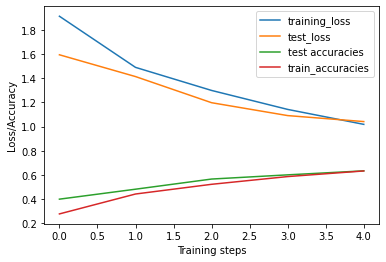

In [55]:
 #1. instantiate model
model = ResidualConnectedCNN()

# 2. choose a path to save the weights
save_path = "trained_model_RUN1"

test_losses, test_accuracies, train_losses,train_accuracies = training_loop(model=model,
    train_ds=train_ds,
    test_ds=test_ds,
    start_epoch=0,
    epochs=5,
    train_summary_writer=train_summary_writer,
    test_summary_writer=test_summary_writer,
    save_path=save_path)

#print(test_losses, test_accuracies, train_losses,train_accuracies)

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
line4,= plt.plot(train_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3,line4),("training_loss","test_loss","test accuracies","train_accuracies"))
plt.show()


In [ ]:
# open the tensorboard logs
%tensorboard --logdir logs/